<div style="text-align: center;">
  <img src="../images/logo.png" alt="sdatools Logo" style="width: 200px;">
</div>

-----------------

# Calibrating a Total Return Index model

**Author**: Mike Fuller

**Last Updated**: 14th August 2025

## Contents

1. [The model](#the-model)
2. [The approach](#the-approach)
3. [The calculation](#the-calculation)
    - [Data sourcing](#data-sourcing)
    - [Data processing](#data-processing)
    - [Strip out systematic risk](#strip-out-systematic-risk)
    - [Log-transform the excess index](#log-transform-the-excess-index)
    - [De-trend the resulting index](#de-trend-the-resulting-index)
    - [Calculate excess log-returns](#calculate-excess-log-returns)
    - [Fitting a distribution to the residuals](#fitting-a-distribution-to-the-residuals)
4. [Next steps](#next-steps)

This case study shows how to use the Method of Moments functionality in `sdatools` to calibrate a Total Return Index (TRI) model to historic data. Such a calibration could then be used to generate stochastic scenarios for the TRI.

For this demonstration, we will use the S&P 500 TRI, obtained from Yahoo Finance using the `yfinance` Python package.

## The model

Given a index with frequency (or step size) $\Delta t$, denote $TRI_t$ as the value of the total return index at time $t$, and $LR_{t}$ as the index log-returns over the step up to time $t$, so that we can write:

$$
TRI_{t+\Delta t} = TRI_t \, e^{LR_{t+\Delta t}}. \tag{1.1}
$$

We will model the log-returns of the index as a sum of:
- some **systematic risk**, $r_t$, e.g. a risk-free rate or inflation rate,
- a **risk-premium process**, $RP_t$,
- a **volatility process**, $\sigma_t$.

With this approach, we have the formula:

$$
LR_{t+\Delta t} = \ln\left(\frac{r_{t+\Delta t}}{r_t}\right) + RP_{t+\Delta t} \, \Delta t 
+ \sigma_{t+\Delta t} \, Z_{t+\Delta t} \, \sqrt{\Delta t}.\tag{1.2}
$$

Here $Z_t$ is a sample from a distribution fitted to the residuals of the total return index.

## The approach

We will calculate residuals of the TRI by stripping away explanatory components of the index until we are left with just volatility - effectively reverse-engineering the equations $(1.1)$, $(1.2)$ to obtain $Z_t$. The process is as follows:

1. Strip out the systematic risk from the total return index,
2. Log-transform the excess index,
3. De-trend the resulting index by subtracting e.g. its mean value, or a linear trend (this is the risk premium),
4. Calculate the returns of the resulting index.

The distribution of the resulting series captures the volatility of the TRI with all explanatory components stripped out. We'll then use `sdatools` to fit an appropriate distribution to this series.

## The calculation

### Data sourcing

First, let's get our index and systematic data. The ticker `^SP500TR` from Yahoo Finance prodives the S&P 500 total return index:

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Load total return index for the S&P 500
start: str = '2000-01-01'
end: str = datetime.today().strftime('%Y-%m-%d')
sp500tr: pd.DataFrame = yf.download('^SP500TR', start=start, end=end, auto_adjust=True) # type: ignore

# Show the first few rows
print(sp500tr.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open   Volume
Ticker         ^SP500TR     ^SP500TR     ^SP500TR     ^SP500TR ^SP500TR
Date                                                                   
2000-01-03  2002.109985  2002.109985  2002.109985  2002.109985        0
2000-01-04  1925.410034  1925.410034  1925.410034  1925.410034        0
2000-01-05  1929.280029  1929.280029  1929.280029  1929.280029        0
2000-01-06  1931.510010  1931.510010  1931.510010  1931.510010        0
2000-01-07  1983.829956  1983.829956  1983.829956  1983.829956        0


<Axes: title={'center': 'S&P 500 Total Return Index'}, xlabel='Date', ylabel='Index'>

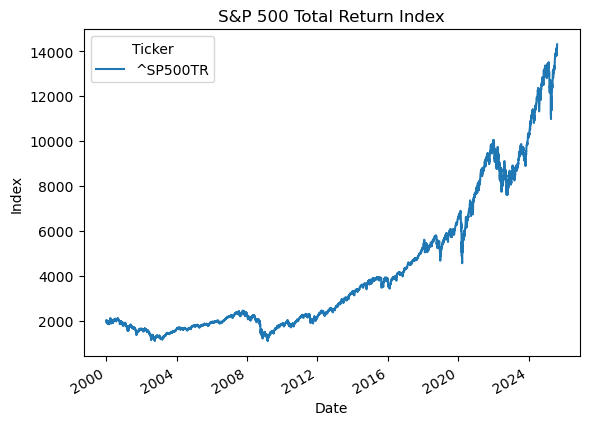

In [2]:
# Plot the closing levels
sp500tr['Close'].plot(title='S&P 500 Total Return Index', ylabel='Index')

Now we need a systematic risk. For this demonstration, we will use a proxy for the risk-free rate via the ticker `^IRX` from Yahoo Finance, which gives the 3-month US Treasury bill yield:

In [3]:
# 3-Month Treasury bill yield (risk-free rate proxy)
irx: pd.DataFrame = yf.download('^IRX', start=start, end=end, auto_adjust=True) # type: ignore

# View yield (in percent)
print(irx.head())

[*********************100%***********************]  1 of 1 completed

Price      Close  High   Low  Open Volume
Ticker      ^IRX  ^IRX  ^IRX  ^IRX   ^IRX
Date                                     
2000-01-03  5.27  5.30  5.23  5.23      0
2000-01-04  5.27  5.29  5.27  5.29      0
2000-01-05  5.27  5.30  5.26  5.30      0
2000-01-06  5.24  5.27  5.24  5.26      0
2000-01-07  5.22  5.28  5.22  5.25      0


<Axes: title={'center': 'US 3-Month Treasury Bill Yield'}, xlabel='Date', ylabel='Yield (%)'>

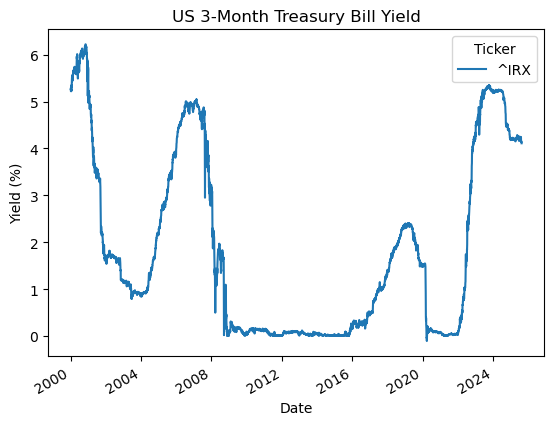

In [4]:
# Plot the closing levels
irx['Close'].plot(title='US 3-Month Treasury Bill Yield', ylabel='Yield (%)')

### Data processing

We'll need to do some data transformation to compare these time series like-for-like. Let's convert the risk-free rate proxy into an index, and rebase it and the TRI to the same starting point:

In [5]:
# Combine TRI index and risk-free rate data into a single DataFrame
# Note: Yahoo Finance uses multiple indices (price and ticker), so we need to reference both
data = pd.merge(
    sp500tr[('Close', '^SP500TR')].rename('TR_Index'),
    irx[('Close', '^IRX')].rename('RF_Return'),
    left_index=True,
    right_index=True
)

# Convert the risk-free rate into a percentage
data['RF_Return'] = data['RF_Return'] / 100

# Convert the risk-free rate into an index
data['RF_Index'] = (1 + data['RF_Return'] / 100).cumprod()

# Rebase both indices to the same starting point
data['TR_Index'] = data['TR_Index'] / data['TR_Index'].iloc[0]
data['RF_Index'] = data['RF_Index'] / data['RF_Index'].iloc[0]

# Remove rows with NaN values (due to rolling window)
data.dropna(inplace=True)

print(data.head())

            TR_Index  RF_Return  RF_Index
Date                                     
2000-01-03  1.000000     0.0527  1.000000
2000-01-04  0.961690     0.0527  1.000527
2000-01-05  0.963623     0.0527  1.001054
2000-01-06  0.964737     0.0524  1.001579
2000-01-07  0.990870     0.0522  1.002102


<Figure size 1400x700 with 0 Axes>

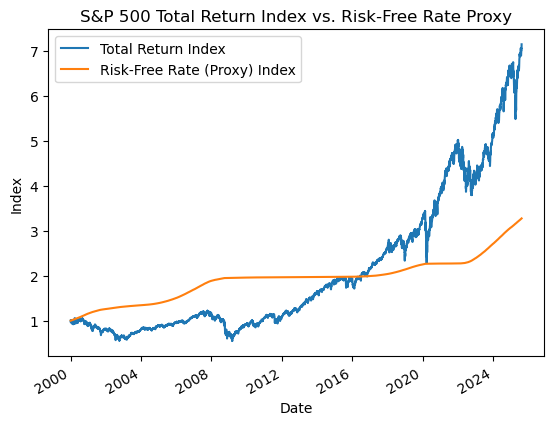

In [6]:
# Plot both indices on the same graph
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
data[['TR_Index', 'RF_Index']].plot(title='S&P 500 Total Return Index vs. Risk-Free Rate Proxy')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(['Total Return Index', 'Risk-Free Rate (Proxy) Index'])
plt.show()

### Strip out systematic risk

Now we can follow the steps outlined in Section 2 to obtain the pure volatility series. First, let's strip out the systematic risk:

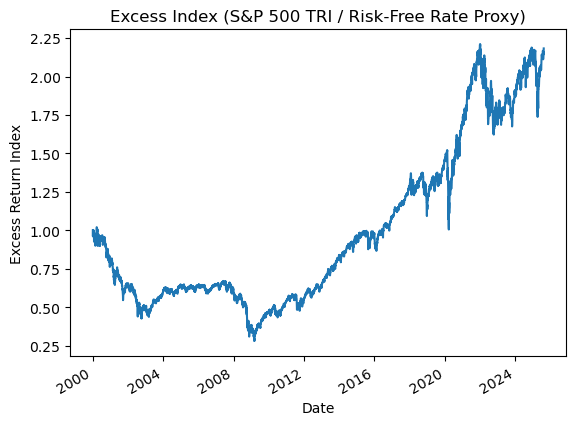

In [7]:
# Strip out the systematic risk
data['Excess_Index'] = data['TR_Index'] / data['RF_Index']

# Plot the excess index
data['Excess_Index'].plot(title='Excess Index (S&P 500 TRI / Risk-Free Rate Proxy)')
plt.xlabel('Date')
plt.ylabel('Excess Return Index')
plt.show()

### Log-transform the excess index

Now we take logs:

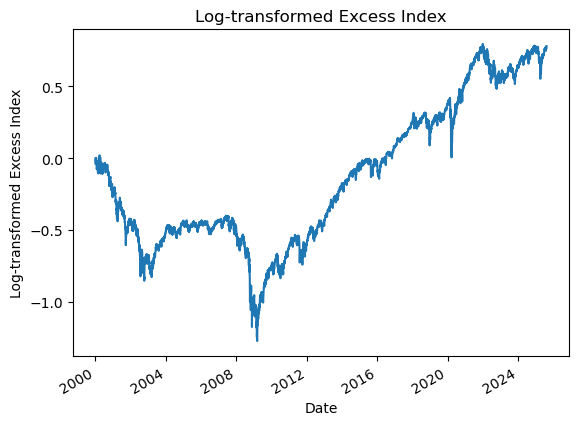

In [8]:
import numpy as np

# Log-transform the excess index
data['Log_Excess_Index'] = np.log(data['Excess_Index'])

# Plot the log-transformed excess return
data['Log_Excess_Index'].plot(title='Log-transformed Excess Index')
plt.xlabel('Date')
plt.ylabel('Log-transformed Excess Index')
plt.show()

### De-trend the resulting index

To strip out the trend (risk premium) of the excess log-returns, we need to identify what trend to remove. Judging from the plot above, a linear trend seems reasonable. Let's run a regression through the excess log-returns:

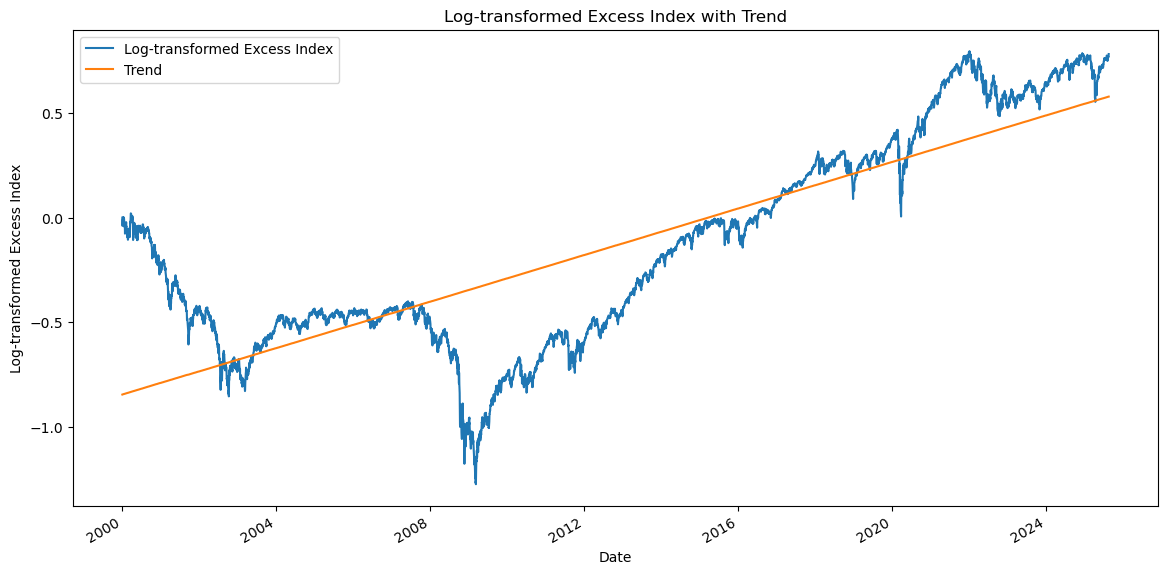

In [9]:
# TODO: Implement LinearRegression in sdatools and use it here
from sklearn.linear_model import LinearRegression

# Prepare data for regression
X: np.ndarray = np.arange(len(data)).reshape(-1, 1)  # Time index
y: np.ndarray = np.asarray(data['Log_Excess_Index'].values)
model = LinearRegression()
model.fit(X, y)

# Get the trend line
data['Trend'] = model.predict(X)

# Plot the log excess return and the trend
plt.figure(figsize=(14, 7))
data['Log_Excess_Index'].plot(title='Log-transformed Excess Index with Trend')
data['Trend'].plot()
plt.xlabel('Date')
plt.ylabel('Log-transformed Excess Index')
plt.legend(['Log-transformed Excess Index', 'Trend'])
plt.show()

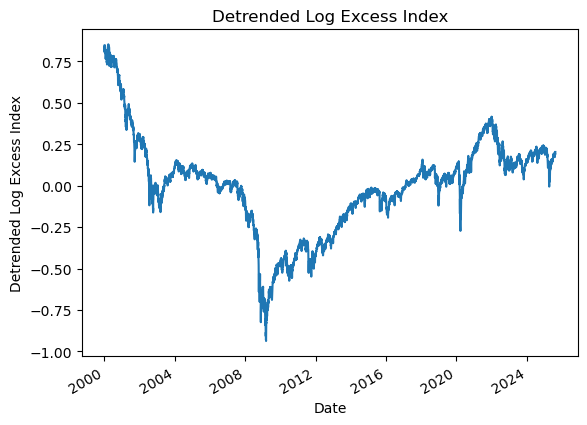

In [10]:
# Detrend the log excess return
data['Detrended_Log_Excess_Index'] = data['Log_Excess_Index'] - data['Trend']

# Plot the detrended log excess return
data['Detrended_Log_Excess_Index'].plot(title='Detrended Log Excess Index')
plt.xlabel('Date')
plt.ylabel('Detrended Log Excess Index')
plt.show()

### Calculate excess log-returns

With all explanatory components stripped out of the index, we can now calculate the annualised returns and observe the distribution.

In [11]:
# Calculate daily excess log-returns
daily_log_returns = data['Detrended_Log_Excess_Index'].diff().dropna()

# Calculate annualised excess log-returns (i.e. residuals)
rolling_log_return = daily_log_returns.rolling(window=252).sum()# Assuming 252 trading days in a year
data['Residuals'] = np.exp(rolling_log_return) - 1

# Remove NaN values from residuals
data.dropna(subset=['Residuals'], inplace=True)

print(data[['Detrended_Log_Excess_Index', 'Residuals']].head())

            Detrended_Log_Excess_Index  Residuals
Date                                             
2001-01-02                    0.528148  -0.271221
2001-01-03                    0.576381  -0.204147
2001-01-04                    0.565056  -0.214100
2001-01-05                    0.537751  -0.235582
2001-01-08                    0.535314  -0.257003


### Fitting a distribution to the residuals

We are now ready to fit a distribution. Let's look at the distribution of the residuals we are fitting to, using the `Histogram` class in `sdatools`:

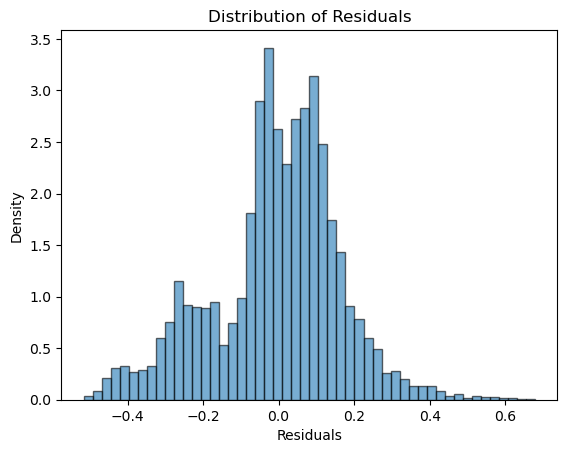

[-0.27122078 -0.20414681 -0.21410036 ...  0.05311361  0.04119558
  0.03971035]
-0.5152796789417466
0.678114664591627


In [12]:
from sdatools.data_visualisation.histogram import Histogram

# Plot the fitted distribution against the histogram of residuals
residuals = data['Residuals']
hist = Histogram(data=residuals)
hist.plot_data(title='Distribution of Residuals', xlabel='Residuals', ylabel='Density')
hist.show()

print(hist.data)
print(hist.min)
print(hist.max)

Naively, let's attempt to fit a Normal distribution to this data. The following code demonstrates this, using `sdatools`:

In [13]:
from sdatools.parameter_estimation.method_of_moments import MethodOfMoments
from sdatools.distributions.continuous.normal import NormalDistribution

# Fit a Normal distribution to the residuals
mom = MethodOfMoments(data['Residuals'])
fitted_normal: NormalDistribution = mom.fit(NormalDistribution)

# Display the fitted parameters
print(f"Fitted Lognormal Distribution Parameters:\n"
      f"Mean (mu): {fitted_normal.mu}\n"
      f"Stddev (sigma): {fitted_normal.sigma}"
)

Fitted Lognormal Distribution Parameters:
Mean (mu): -0.006578198645738292
Stddev (sigma): 0.16925007202885767


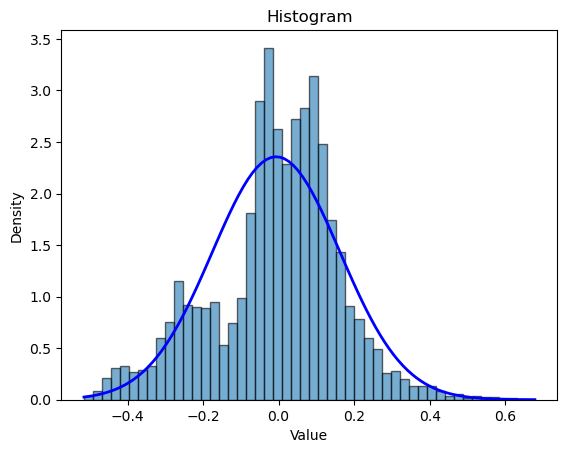

In [14]:
# Overlay the PDF on the histogram
# TODO: Remove need to re-instantiate the histogram in Jupyter notebooks
hist = Histogram(data=residuals)
hist.plot_data()
hist.overlay_pdf(distribution=fitted_normal, color='blue')
hist.show()

The fitted Normal distribution doesn't do a great job. Note that the distribution has positive skew: this is common for real-world equity returns since equity markets often grow upwards slowly, but occasionally they will crash quickly, as was seen in the 2008 global financial crisis. A Normal distribution has no skew, and would not capture this behaviour. 

With this in mind, let's attempt to fit to a skew-normal distribution, to capture the skew of the residuals. Again, we use `sdatools`:

In [15]:
from sdatools.distributions.continuous.skewnormal import SkewNormalDistribution

# Fit a Normal distribution to the residuals
fitted_skewnormal: SkewNormalDistribution = mom.fit(SkewNormalDistribution)

# Display the fitted parameters
print(f"Fitted Skew-Normal Distribution Parameters:\n"
      f"Location (xi): {fitted_skewnormal.xi}\n"
      f"Scale (omega): {fitted_skewnormal.omega}\n"
      f"Shape (alpha): {fitted_skewnormal.alpha}"
)

Fitted Skew-Normal Distribution Parameters:
Location (xi): 0.033240914927080416
Scale (omega): 0.16419790639281026
Shape (alpha): -0.3190298844101283


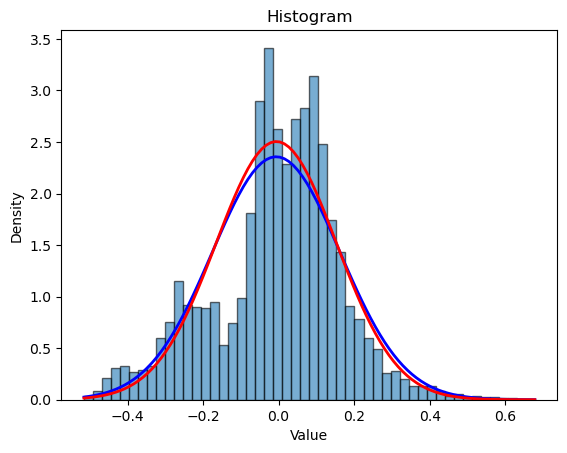

In [16]:
# Overlay the PDF on the histogram
# TODO: Remove need to re-instantiate the histogram in Jupyter notebooks
hist = Histogram(data=residuals)
hist.plot_data()
hist.overlay_pdf(distribution=fitted_normal, color='blue')
hist.overlay_pdf(distribution=fitted_skewnormal, color='red')
hist.show()

The fit is improved marginally, but not by much. Let's confirm this quantitatively with a Kolmogorov-Smirnov test:

KS statistic: 0.075728
p-value: 0.000000
KS test against SkewNormalDistribution FAILED


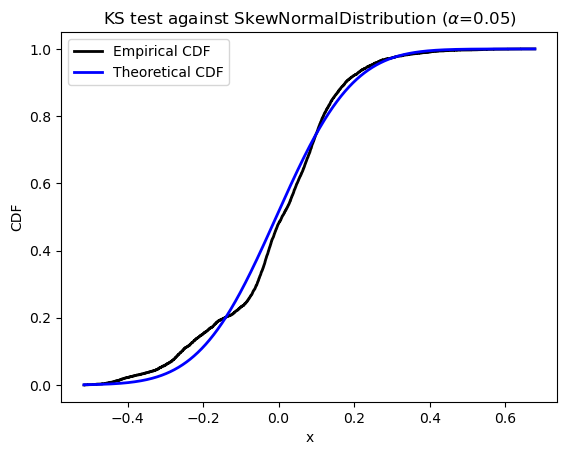

In [17]:
from sdatools.validation.goodness_of_fit.ks_test import KSTest

ks_test = KSTest(data=residuals)
ks_test.test(dist=fitted_skewnormal)

We need a distribution that is better at modelling fat tails to proceed.

## Next steps

From the Kolmogorov-Smirnov test, we can see that the skew-normal distribution does not do an adequate job of modelling the distribution of residuals. There are two next steps that come to mind in order to continue this case study:

- **Implement a more flexible distribution** - I will implement the Method of Moments for the **Johnson SU** distribution next, to attempt a better fit to the residual data with fatter tails.
- **Try re-calibrating to monthly data** - for long-term scenario projections, it may be more appropriate to consider data with larger time steps. I will re-run the calibration and validation process on monthly data.

Once an appropriate distribution has been fitted, I will demonstrate how to use the distribution to generate future scenarios of the S&P 500 total return index.